In [1]:
import os
user = os.getenv('USER')
import sys
sys.path.insert(0, f'/Home/{user}/py/stereoid')

In [2]:
import glob

import numpy as np
import matplotlib.pyplot as plt
import pyproj
from skimage.measure import regionprops_table
from skimage import morphology

import drama.utils as drtls
from drama.io import cfg as cfg
from drama.geo import SingleSwathBistatic

import stereoid.sar_performance as strsarperf
import stereoid.oceans.tools.observation_tools as obs_tools
from stereoid.sea_ice import FwdModel, SceneGenerator, RetrievalModel

from harmony23lib import *

In [3]:
# Run ID
mode = "IWS"
runid='2021_1_seaice'

# stereoid path
path=f'/data1/{user}/stereoid'
pardir=path + '/PAR/'
parfile=pardir + 'Hrmny_' + '2021_1_seaice' + '.cfg'
cfgdata = cfg.ConfigFile(drtls.get_par_file(parfile))
main_dir=path + ''

# input neXtSIM files
model_dir=path + '/nextsim/'

# radar model
#fstr_dual = strsarperf.sarperf_files(main_dir, rx_dual_name, mode=mode, runid=runid) # at the moment IW only I think
fstr_ati = strsarperf.sarperf_files(main_dir, 'tud_2020_tripple_ati', mode=mode, runid=runid)
fstr_s1 = strsarperf.sarperf_files(main_dir, 'sentinel', mode=mode, runid=runid, is_bistatic=False)

# some additional settings
x_res=cfgdata.sar.gr_res # is readily set 
y_res=cfgdata.sar.gr_res # make it equal to the monostatic ground-range resolution
t_res=cfgdata.orbit.timestep # along-track time resolution of generated swath
sp=[complex(1.6,0.07), 0.0030, 0.015, 0.04] 
ip=[complex(3.65,0.38), 0.0030, 0.015] 
pol='hh+hv'
prod_res = np.sqrt(x_res * y_res)
b_ati=10
t_orb=12/175

inc_m_deg=31.1
inc_m = np.deg2rad(inc_m_deg)
along_track_separation=375e3 # should be consistent with the PAR file
obs_geo = obs_tools.build_geometry(parfile, inc_m, dau=along_track_separation)

fwdm = FwdModel(parfile,sp,ip)# initialize forwaes model
sgm = SceneGenerator(fwdm,x_res,y_res,n_orbs=2) # initialize scene generator
proj = pyproj.proj.Proj('+proj=stere +lat_0=90 +lat_ts=75')
n_orbits=10

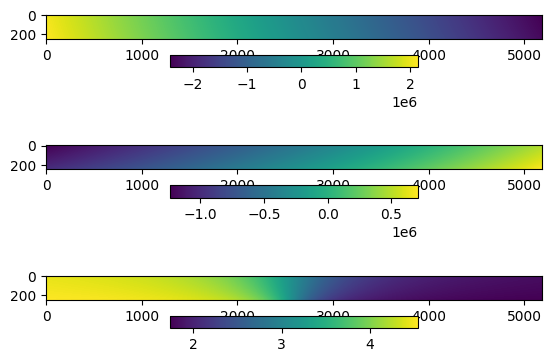

In [4]:
# create Swath generator
swb = SingleSwathBistatic(par_file=parfile, dau=along_track_separation, n_orbits=1)
swth_bst = next(swb)
# create swath grids with X, Y in polar stereographic projection
x_sz, y_sz, nor_sz = create_swath_grids(swth_bst, proj, t_res, y_res)

plt.subplot(3,1,1)
plt.imshow(x_sz.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.subplot(3,1,2)
plt.imshow(y_sz.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.subplot(3,1,3)
plt.imshow(nor_sz.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.show()

In [5]:
# read coordinates of nodes, u, v and concentration and triangulation from nextsim mesh
# X, Y are in polar stereographic projection
filename = f'/data1/{user}/stereoid/nextsim/exp_00012/field_20070105T120000Z.npz'
x, y, v_e, v_n, c, t = read_nextsim_data(filename, proj)

In [ ]:
# Create grids with neXtSIM U, V, landmask and ice mask in SWATH projection
v_e_sz, v_n_sz, landmask, icemask = interpolate_nextsim_on_swath(x, y, v_e, v_n, c, t, x_sz, y_sz)

v_e_sz[icemask.mask] = np.nan
v_n_sz[icemask.mask] = np.nan

row0, row1 = 1600, 3000
vmax = 0.1
fig, axs = plt.subplots(1,2, figsize=(20,5))
imsh = axs[0].imshow(v_e_sz[row0:row1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(v_n_sz[row0:row1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
plt.tight_layout()

In [ ]:
# Compute range and azimuth components of U and V
u_int, v_int = compute_nextsim_uv(v_e_sz, v_n_sz, landmask, nor_sz)

fig, axs = plt.subplots(1,2, figsize=(20,5))
imsh = axs[0].imshow(u_int[row0:row1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(v_int[row0:row1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
plt.tight_layout()

In [ ]:
dopp, s_dopp, r_dopp_r0 = get_doppler(sgm, obs_geo, u_int, v_int, x_res, pol, inc_m, fstr_s1, fstr_ati, prod_res, b_ati)

vmax = 6
fig, axs = plt.subplots(1,3, figsize=(20,5))
imsh = axs[0].imshow(s_dopp[row0:row1,:,0].T, cmap='bwr', clim=[0,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(s_dopp[row0:row1,:,1].T, cmap='bwr', clim=[0,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
imsh = axs[2].imshow(s_dopp[row0:row1,:,2].T, cmap='bwr', clim=[0,vmax])
plt.colorbar(imsh, ax=axs[2], orientation='horizontal', shrink=0.5)
plt.tight_layout()

vmax = 4
fig, axs = plt.subplots(1,3, figsize=(20,5))
imsh = axs[0].imshow(r_dopp_r0[row0:row1,:,0].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(r_dopp_r0[row0:row1,:,1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
imsh = axs[2].imshow(r_dopp_r0[row0:row1,:,2].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[2], orientation='horizontal', shrink=0.5)
plt.tight_layout()

In [ ]:
r_dopp_d0 = remove_texture_noise(r_dopp_r0, s_dopp)
fig, axs = plt.subplots(1,3, figsize=(20,5))
imsh = axs[0].imshow(r_dopp_d0[row0:row1,:,0].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(r_dopp_d0[row0:row1,:,1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
imsh = axs[2].imshow(r_dopp_d0[row0:row1,:,2].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[2], orientation='horizontal', shrink=0.5)
plt.tight_layout()

In [ ]:
r_dopp_mk = np.zeros_like(r_dopp_r0[row0:row1])
for i in range(3):
    r_dopp_mk[:,:,i] = denoise_mk(dopp[row0:row1,:,i], r_dopp_d0[row0:row1,:,i])

fig, axs = plt.subplots(1,3, figsize=(20,5))
imsh = axs[0].imshow(r_dopp_mk[:,:,0].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(r_dopp_mk[:,:,1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
imsh = axs[2].imshow(r_dopp_mk[:,:,2].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[2], orientation='horizontal', shrink=0.5)
plt.tight_layout()

In [ ]:
r_dopp_ad = np.zeros_like(r_dopp_r0[row0:row1])
for i in range(3):
    r_dopp_ad[:,:,i] = apply_anisotropic_diffusion(r_dopp_mk[:,:,i], kappa=5)

fig, axs = plt.subplots(1,3, figsize=(20,5))
imsh = axs[0].imshow(r_dopp_ad[:,:,0].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(r_dopp_ad[:,:,1].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
imsh = axs[2].imshow(r_dopp_ad[:,:,2].T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[2], orientation='horizontal', shrink=0.5)
plt.tight_layout()    

In [ ]:
retrievalm = RetrievalModel(obs_geo.concordia, obs_geo.discordia, parfile)
uv = retrievalm.sea_ice_drift(np.array(r_dopp_ad))

vmax = -0.1
fig, axs = plt.subplots(1,2, figsize=(20,5))
imsh = axs[0].imshow(uv[:,:,0].T, cmap='bwr', clim=[-vmax,vmax], interpolation='nearest')
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(uv[:,:,1].T, cmap='bwr', clim=[-vmax,vmax], interpolation='nearest')
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
plt.tight_layout()    

In [ ]:
ui = u_int[row0:row1]
vi = v_int[row0:row1]
uh = uv[:,:,0]
vh = uv[:,:,1]

In [ ]:
stp = 2
divi, shei, toti = get_deformation(ui[::stp, ::stp], vi[::stp, ::stp])

uz = multi_look(uh, stp)
vz = multi_look(vh, stp)
# RAW
divz, shez, totz = get_deformation(uz, vz)

# MK
X, Y = get_edges_x_y_mk(uz, vz, size1=12, size2=13, thr=-4.9)
ColNrs, RowNrs = morph_operators_mk(uz, X, Y)
f_m, divm, shem  = get_deformation_components_mk(uz, vz, ColNrs, RowNrs)
totm = np.hypot(divm, shem)    

# AK
uc, vc = clustering_filter(uz, vz, n_clusters=40, med_filt_size=5, xy_interpolation=True)
divh, sheh, toth = get_deformation(uc, vc)

vmax = 0.05
fig, axs = plt.subplots(1,2, figsize=(20,5))
imsh = axs[0].imshow(divi.T, cmap='bwr', clim=[-vmax,vmax])
imsh = axs[1].imshow(shei.T, cmap='jet', clim=[0,vmax])
plt.tight_layout()    

fig, axs = plt.subplots(1,2, figsize=(20,5))
imsh = axs[0].imshow(divz.T, cmap='bwr', clim=[-vmax,vmax])
imsh = axs[1].imshow(shez.T, cmap='jet', clim=[0,vmax])
plt.tight_layout()    

fig, axs = plt.subplots(1,2, figsize=(20,5))
imsh = axs[0].imshow(divm.T, cmap='bwr', clim=[-vmax,vmax])
imsh = axs[1].imshow(shem.T, cmap='jet', clim=[0,vmax])
plt.tight_layout()    

fig, axs = plt.subplots(1,2, figsize=(20,5))
imsh = axs[0].imshow(divh.T, cmap='bwr', clim=[-vmax,vmax])
plt.colorbar(imsh, ax=axs[0], orientation='horizontal', shrink=0.5)
imsh = axs[1].imshow(sheh.T, cmap='jet', clim=[0,vmax])
plt.colorbar(imsh, ax=axs[1], orientation='horizontal', shrink=0.5)
plt.tight_layout()